<a href="https://colab.research.google.com/github/petonorbert/petonorbert.github.io/blob/master/Norbert_Peto_5th_Data_mining_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining 5th competition

2022 05

Norbert Pető

## Rules

For the final challenge, there will be only one competition.

Goal: predict the binary labels for the whole dataset.
Metric: balanced accuracy.

Rules

*You can only use unsupervised/self-supervised methods*. For 500 records, the labels are provided; you can use those for evaluating models, but not training. Apart from that, you can use any models and techniques that you see fit.
You can have up to three submissions, and the best of those will count for the final challenge. Your submissions *must have* the same format as comp_5_sample_submission.csv (containing either a 'yes' or 'no' in each column, in the order the dataset is originally given, without row numbers or headers), and it must have your name in the filename.


--- ---

## Data description

    Age (numeric)
    Job : type of job (categorical: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 
    'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown')
    Marital : marital status (categorical: 'divorced', 'married', 'single',
     'unknown' ; note: 'divorced' means divorced or widowed)
    Education (categorical: 'basic.4y', 'basic.6y', 'basic.9y', 'high.school',
     'illiterate', 'professional.course', 'university.degree', 'unknown')
    Default: has credit in default? (categorical: 'no', 'yes', 'unknown')
    Housing: has housing loan? (categorical: 'no', 'yes', 'unknown')
    Loan: has personal loan? (categorical: 'no', 'yes', 'unknown')

Related with the last contact of the current campaign:

    Contact: contact communication type (categorical: 'cellular','telephone')
    Month: last contact month of year (categorical: 'jan', 'feb', 'mar', …, 'nov', 'dec')
    Dayofweek: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

Other attributes:

    Campaign: number of contacts performed during this campaign and for
    this client (numeric, includes last contact)
    Pdays: number of days that passed by after the client was last    
    contacted from a previous campaign (numeric; 999 means client was not
    previously contacted)
    Previous: number of contacts performed before this campaign and for
    this client (numeric)
    Poutcome: outcome of the previous marketing campaign (categorical:
    'failure','nonexistent','success')

Social and economic context attributes

    Emp.var.rate: employment variation rate - quarterly indicator
    (numeric)
    Cons.price.idx: consumer price index - monthly indicator (numeric)
    Cons.conf.idx: consumer confidence index - monthly indicator
    (numeric)
    Euribor3m: euribor 3 month rate - daily indicator (numeric)
    Nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target): has the client subscribed a term deposit? (binary: 'yes', 'no')

--- ---

## Import toolsets and data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay as cm_disp
import sklearn as skl
from sklearn.cluster import KMeans, DBSCAN

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
url_train="https://drive.google.com/file/d/1VfQBsxnGkUZsP9V4vLlTltmGwwXY4z4L/view?usp=sharing"
url_labels="https://drive.google.com/file/d/1QXRR7XPhdaha4WMegcNuMQjCZuYMelhu/view?usp=sharing"
url_train='https://drive.google.com/uc?id='+url_train.split('/')[-2]
df_train = pd.read_csv(url_train)
url_labels='https://drive.google.com/uc?id='+url_labels.split('/')[-2]
df_labels=pd.read_csv(url_labels, names=["labels"])

In [ ]:
df_train.head(-10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,59,admin.,married,professional.course,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30473,31,admin.,single,university.degree,no,yes,no,cellular,nov,thu,1,999,0,nonexistent,-1.1,94.767,-50.8,1.031,4963.6
30474,62,retired,married,university.degree,no,yes,no,cellular,nov,thu,1,999,2,failure,-1.1,94.767,-50.8,1.031,4963.6
30475,62,retired,married,university.degree,no,yes,no,cellular,nov,thu,1,1,6,success,-1.1,94.767,-50.8,1.031,4963.6
30476,38,housemaid,divorced,high.school,no,yes,yes,cellular,nov,thu,1,999,0,nonexistent,-1.1,94.767,-50.8,1.031,4963.6


In [ ]:
df_train[df_train.loan=="unknown"]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed


--- ---

## Descriptive data analysis

### numerical and categorical feature identification

In [ ]:
cat_feat=list(df_train.columns[df_train.dtypes==object])
num_feat=list(df_train.columns[df_train.dtypes!=object])
print(cat_feat)
print(num_feat)
print(len(cat_feat), len(num_feat), len(df_train.columns))

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
10 9 19


--- ---

### missing items

In [ ]:
missing_list=df_train.isna().sum()/len(df_train)*100
missing_list=missing_list.sort_values()

#print("\nProportion of missing values by column:\n\n", missing_list)

miss_df=pd.DataFrame({"missing_train_%": missing_list, "missing_train_qty": df_train.isna().sum(),
                      "missing_label_%": df_labels.isna().sum()/len(df_labels)*100, "missing_label_qty": df_labels.isna().sum()})
miss_df

,missing_train_%,missing_train_qty,missing_label_%,missing_label_qty
age,0.0,0.0,NaN,NaN
campaign,0.0,0.0,NaN,NaN
cons.conf.idx,0.0,0.0,NaN,NaN
cons.price.idx,0.0,0.0,NaN,NaN
contact,0.0,0.0,NaN,NaN
day_of_week,0.0,0.0,NaN,NaN
default,0.0,0.0,NaN,NaN
education,0.0,0.0,NaN,NaN
emp.var.rate,0.0,0.0,NaN,NaN
euribor3m,0.0,0.0,NaN,NaN


There are no missing items in the dataframe. There is indeed only 500 labels available (as pointed out in the task description).
--- ---


The data description suggests that there are missing data labelled "unknown".

In [ ]:
unknown_list=df_train[df_train=="unknown"].sum()/len(df_train)*100
unknown_list=unknown_list.sort_values()

#print("\nProportion of missing values by column:\n\n", missing_list)

unknown_df=pd.DataFrame({"missing_train_%": unknown_list, "missing_train_qty": df_train[df_train=="unknown"].sum(),
                      "missing_label_%": df_labels[df_labels=="unknown"].sum()/len(df_labels)*100, "missing_label_qty": df_labels[df_labels=="unknown"].sum()})
unknown_df

,missing_train_%,missing_train_qty,missing_label_%,missing_label_qty
age,0.0,0.0,NaN,NaN
campaign,0.0,0.0,NaN,NaN
cons.conf.idx,0.0,0.0,NaN,NaN
cons.price.idx,0.0,0.0,NaN,NaN
contact,0.0,0,NaN,NaN
day_of_week,0.0,0,NaN,NaN
default,0.0,0,NaN,NaN
education,0.0,0,NaN,NaN
emp.var.rate,0.0,0.0,NaN,NaN
euribor3m,0.0,0.0,NaN,NaN


It seems the dataframe free of "unknown" records.

--- ---

### duplicates

In [ ]:
df_train.duplicated(subset=None, keep= 'first').value_counts()

False    28867
True      1621
dtype: int64

However there are some duplicates, there is no specific identification field that would determine if a row is duplicate or not. The content of columns reasonably allows that there are rows with the same content but they represent distinct people. (For example two 30years old married housewifes with secondary school education, personal loan, mortgage and credit were contacted on the same day). 
For this reason I decided not to eliminate these rows.

If I am wrong and the content of the rows matches due to a data registration error, then that datapoint would be considered with double (triple, etc) "weight" when calculating the center of the cluster. Compared to the expected number of items in the clusters it should be negligible.

### visualisation of data distribution

#### categorical features

In [ ]:
def cat_display(df, cat_feat):
  fig, ax=plt.subplots(2,int(-(-len(cat_feat)//2)), figsize=(20,12))
  plt.tight_layout(pad=11)

  a=0
  b=0

  for i in cat_feat:
    dr=df[i].value_counts(dropna=False)
    x=list(dr.index)
    for n,g in enumerate(x):
      if pd.isnull(g):
        x[n]='nan'
      if pd.isnull(g)!=True:
        x[n]=str(x[n])
    h=list(dr.values)
    ax[a,b].bar(x=x, height=h)
    ax[a,b].set_title(i[:10])
    ax[a,b].set_xticklabels(x, rotation='vertical')
    if b<=int(-(-len(cat_feat)//2))-2:
     b=b+1
    else:
      b=0
      a=a+1

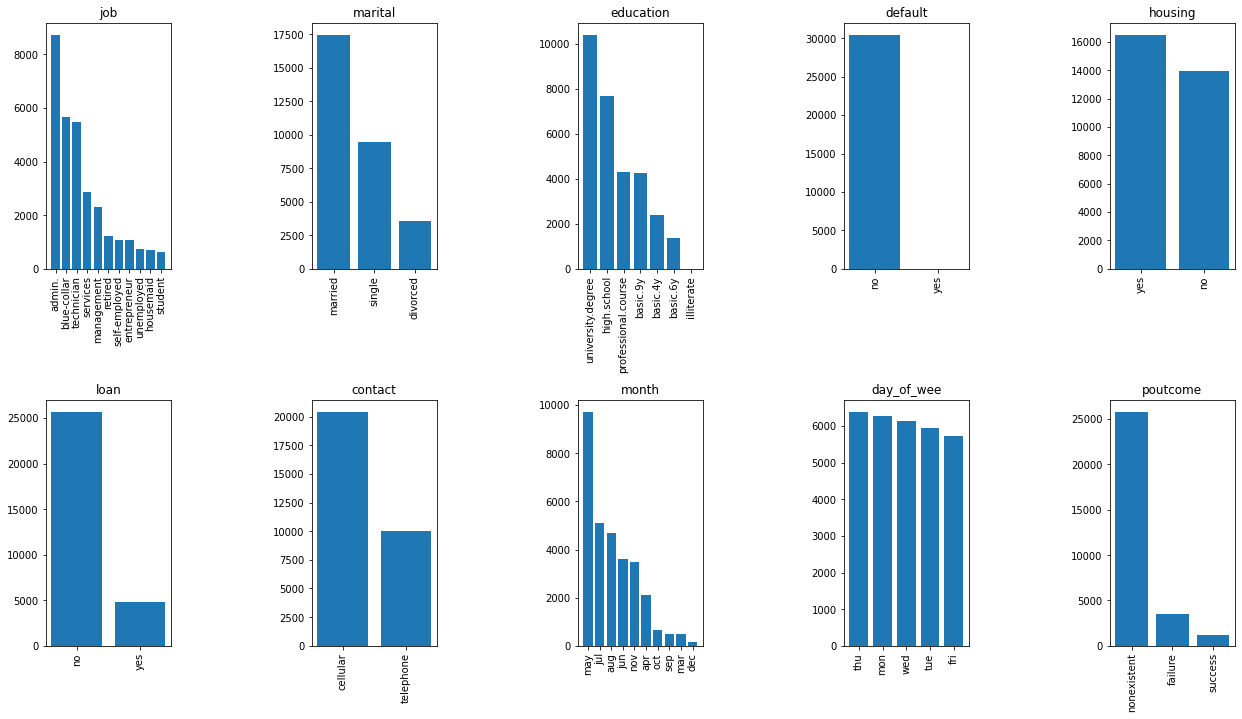

In [ ]:
cat_display(df_train, cat_feat)

In [ ]:
df_train.default.value_counts()

no     30485
yes        3
Name: default, dtype: int64

#### numerical features

In [ ]:
from matplotlib.ticker import FormatStrFormatter

def num_display(df, num_feat):
  fig, ax=plt.subplots(2,int(-(-len(num_feat)//2)), figsize=(15,12))
  plt.tight_layout(pad=2)

  a=0
  b=0

  for i in num_feat:
    ax[a,b].hist(x=list(df[i].values), bins=10)
    counts, bins, patches = ax[a,b].hist(df[i], bins=10)
    bins=np.round(bins,1)

    ax[a,b].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
    ax[a,b].set_xticks(bins)
    ax[a,b].set_xticklabels(bins, rotation=90)
    bin_centers = 0.5 * np.diff(bins) + bins[:-1]

    for count, x in zip(counts, bin_centers):
    # Count labels
      ax[a,b].annotate(str(int(count)), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -46), textcoords='offset points', va='top', ha='center', rotation="vertical")
    # % labels
      #percent = '%0.0f%%' % (100 * float(count) / counts.sum())
      #ax[a,b].annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
    #    xytext=(0, -32), textcoords='offset points', va='top', ha='center', rotation="vertical")

    # Adjust subplot positions for visibility of labels
    plt.subplots_adjust(bottom=0.15, wspace=0.3,hspace=0.5)

    ax[a,b].set_title(i[:10])

    if b<=int(-(-len(num_feat)//2))-2:
     b=b+1
    else:
      b=0
      a=a+1

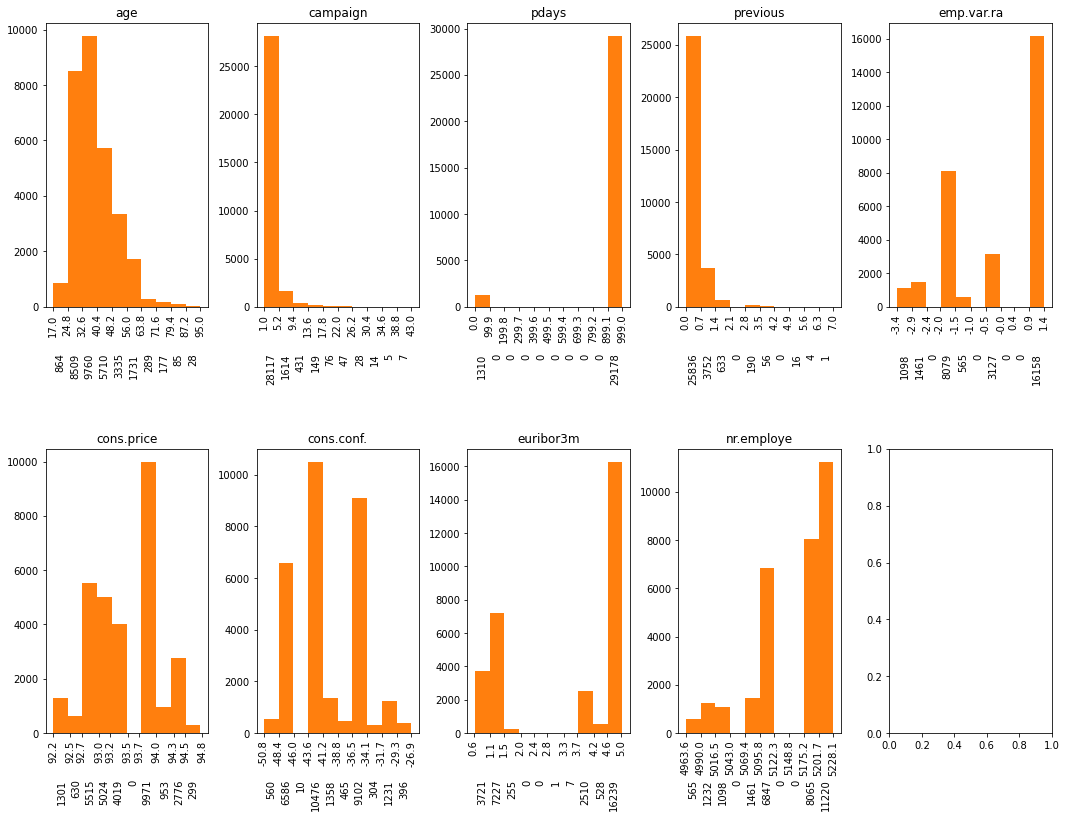

In [ ]:
num_display(df_train, num_feat)

#### data cleaning and preparation for model

In "pdays" feature the the '999' value is an exception code, not real data. Since this means that the "question" is actually not applicable, and only 4% of the records have meaningful value, this feature should be transformed into a categorical feature.
After a trial however I found out that dropping this feature actually gave me better prediction. 
Thus I decided to omit it.

In [ ]:
df_train.pdays.value_counts()[:5]

999    29178
3        381
6        363
4        102
2         53
Name: pdays, dtype: int64

In [ ]:
#cat_feat.remove("poutcome")
num_feat.remove("pdays")
df_train.drop(["pdays"], axis=1, inplace=True)

df_cat_onehot=pd.get_dummies(df_train[cat_feat], columns=cat_feat, prefix=cat_feat)
#cat_feat.extend([""])
df_comb=df_cat_onehot.join(df_train.drop(cat_feat, axis=1))
df_comb.shape

(30488, 55)

## 1st model: kmeans

### model and prediction

In [ ]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(df_comb)
km_pred = kmeans.predict(df_comb)
df_eval=pd.DataFrame(km_pred, columns=["prediction"])
df_eval["labels"]=df_labels.labels
df_eval.loc[df_eval.prediction==0, "prediction"]="no"
df_eval.loc[df_eval.prediction==1, "prediction"]="yes"
df_eval_sample=df_eval.drop(df_eval.loc[df_eval["labels"].isna()==True].index)
df_eval_sample.value_counts()

prediction  labels
no          no        309
yes         no        133
            yes        43
no          yes        15
dtype: int64

In [ ]:
accuracy_score(df_eval_sample.labels.astype(str), df_eval_sample.prediction.astype(str))

0.704

In [ ]:
def bal_acc(cm):
  TPR = cm[1,1] / (cm[1,1] + cm[1,0])
  TNR = cm[0,0] / (cm[0,0] + cm[0,1])
  result = (TPR + TNR) / 2
  return result

In [ ]:
conf=confusion_matrix(df_eval_sample.labels, df_eval_sample.prediction)
bal_acc(conf)

0.720237166484631

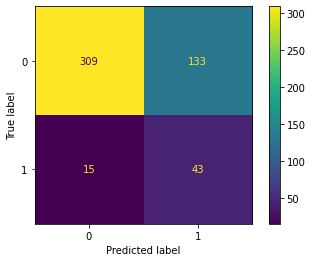

In [ ]:
cm_disp(conf).plot()
plt.show()

this looks quite nice, however during the submission file creation I found out something strange...

### analysis of a strange behavoiur

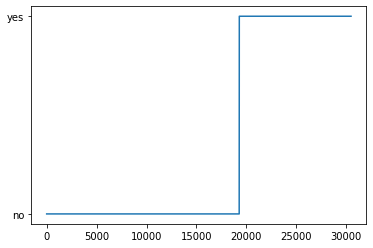

In [ ]:
plt.plot(df_eval.index, df_eval.prediction)

is this really happening?!

In [ ]:
km_pred[19200:19400]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int32)

is this because the dataframe is sorted by a key predictor feature?

In [ ]:
cat_feat

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

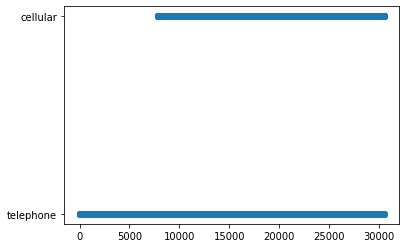

In [ ]:
plt.scatter(df_train.index, df_train.contact)

The first 6000-ish clients in the dataframe were contacted purely over telephone, after that cellphone and telephone occurs in the dataset in mixture.

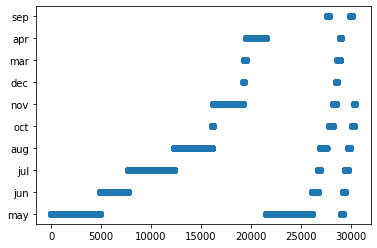

In [ ]:
plt.scatter(df_train.index, df_train.month)

This shows the dataset is ordered by time, but there is also a breakpoint around the index 21000.

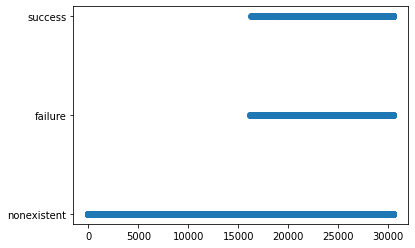

In [ ]:
plt.scatter(df_train.index, df_train.poutcome)

None of the categorical features on its own explains the prediction step at index 19200.

Let's see the numericals.

In [ ]:
num_feat

['age',
 'campaign',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

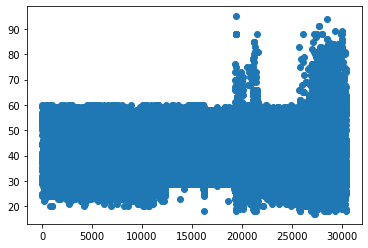

In [ ]:
plt.scatter(df_train.index, df_train.age)

Below index 19000-ish there are no clients older than 60 years. Let's keep it in mind.

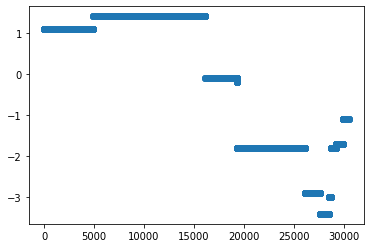

In [ ]:
plt.scatter(df_train.index, df_train["emp.var.rate"])

There also seems to be a breakpoint around index 19000-ish.

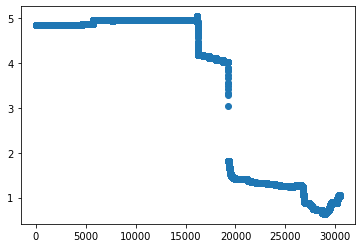

In [ ]:
plt.scatter(df_train.index, df_train["euribor3m"])

There is a breakpoint at around 19000-ish. Let's see where exatly it is.

In [ ]:
df_train[df_train.euribor3m<2][:2]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
19285,26,student,single,basic.9y,no,yes,no,cellular,mar,mon,4,0,nonexistent,-1.8,92.843,-50.0,1.811,5099.1
19286,38,admin.,single,university.degree,no,yes,no,cellular,mar,mon,2,0,nonexistent,-1.8,92.843,-50.0,1.811,5099.1


In [ ]:
df_eval[df_eval.prediction=="yes"][:2]

,prediction,labels
19285,yes,NaN
19286,yes,yes


So this feature is so dominant in the model, that it explains the prediction on its own.
Maybe if we perform standardization, the situation changes.


### kmeans on standardized train set

In [ ]:
SC =StandardScaler()
SC.fit(df_comb)
df_comb_std=pd.DataFrame(SC.transform(df_comb), columns=df_comb.columns, index=df_comb.index)
df_comb_std

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_nonexistent,poutcome_success,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,-0.633784,-0.478237,-0.192463,6.571568,-0.286387,-0.203817,-0.192738,-0.321556,-0.142886,-0.467749,...,0.424333,-0.201625,1.642253,-0.559335,-0.371616,0.727477,0.804095,0.877451,0.786102,0.401648
1,-0.633784,-0.478237,-0.192463,-0.152171,-0.286387,-0.203817,-0.192738,3.109877,-0.142886,-0.467749,...,0.424333,-0.201625,-0.196452,-0.559335,-0.371616,0.727477,0.804095,0.877451,0.786102,0.401648
2,1.577824,-0.478237,-0.192463,-0.152171,-0.286387,-0.203817,-0.192738,-0.321556,-0.142886,-0.467749,...,0.424333,-0.201625,0.093870,-0.559335,-0.371616,0.727477,0.804095,0.877451,0.786102,0.401648
3,-0.633784,-0.478237,-0.192463,-0.152171,-0.286387,-0.203817,-0.192738,3.109877,-0.142886,-0.467749,...,0.424333,-0.201625,1.642253,-0.559335,-0.371616,0.727477,0.804095,0.877451,0.786102,0.401648
4,1.577824,-0.478237,-0.192463,-0.152171,-0.286387,-0.203817,-0.192738,-0.321556,-0.142886,-0.467749,...,0.424333,-0.201625,1.932575,-0.559335,-0.371616,0.727477,0.804095,0.877451,0.786102,0.401648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30483,-0.633784,-0.478237,-0.192463,-0.152171,-0.286387,4.906360,-0.192738,-0.321556,-0.142886,-0.467749,...,0.424333,-0.201625,3.287410,-0.559335,-0.371616,-0.638666,2.124640,-2.129332,-1.368408,-2.624025
30484,-0.633784,2.091013,-0.192463,-0.152171,-0.286387,-0.203817,-0.192738,-0.321556,-0.142886,-0.467749,...,0.424333,-0.201625,0.674513,-0.559335,-0.371616,-0.638666,2.124640,-2.129332,-1.368408,-2.624025
30485,-0.633784,-0.478237,-0.192463,-0.152171,-0.286387,4.906360,-0.192738,-0.321556,-0.142886,-0.467749,...,0.424333,-0.201625,1.642253,-0.191702,-0.371616,-0.638666,2.124640,-2.129332,-1.368408,-2.624025
30486,-0.633784,-0.478237,-0.192463,-0.152171,-0.286387,-0.203817,-0.192738,-0.321556,-0.142886,2.137901,...,0.424333,-0.201625,0.480965,-0.559335,-0.371616,-0.638666,2.124640,-2.129332,-1.368408,-2.624025


In [ ]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(df_comb_std)
km_pred_std = kmeans.predict(df_comb_std)
df_eval_std=pd.DataFrame(km_pred_std, columns=["prediction"])
df_eval_std["labels"]=df_labels.labels
df_eval_std.loc[df_eval_std.prediction==0, "prediction"]="no"
df_eval_std.loc[df_eval_std.prediction==1, "prediction"]="yes"
df_eval_sample_std=df_eval_std.drop(df_eval_std.loc[df_eval_std["labels"].isna()==True].index)
df_eval_sample_std.value_counts()

prediction  labels
no          no        304
yes         no        138
            yes        44
no          yes        14
dtype: int64

In [ ]:
conf_std=confusion_matrix(df_eval_sample_std.labels, df_eval_sample_std.prediction)
bal_acc(conf_std)

0.7232017475425183

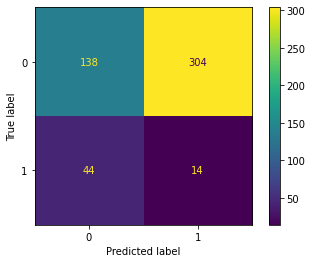

In [ ]:
cm_disp(conf_std).plot()
plt.show()

Well, its not what I call a breakthrough. Most probably it is the same behaviour.

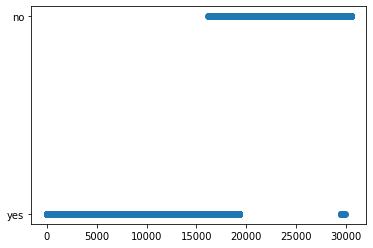

In [ ]:
plt.scatter(df_eval_std.index, df_eval_std.prediction)

Well, there is at least a grey zone where both the potential prediction values appear. And it slighly increased the balanced accuracy as well.

#### submission file

In [ ]:
df_eval_std.prediction.value_counts()

yes    18674
no     11814
Name: prediction, dtype: int64

In [ ]:
df_eval_std.prediction.to_csv('/content/dm_competition5_Norbert_Peto.csv', index = False, header=False)

## DBScan model

In [ ]:
ind=list(df_labels[df_labels.labels.isna()==False].index)
df_train=df_comb_std.loc[ind]

In [ ]:
dbscan=DBSCAN()

parameters={"eps": list(np.linspace(12.5,13.5, 11)), "metric": ["l1"], "min_samples": [10, 50, 100, 200, 250, 500]}

In [ ]:
rnd_src = RandomizedSearchCV(estimator=dbscan, param_distributions = parameters,
                               cv = 5, n_iter = 20, n_jobs=-1, scoring="balanced_accuracy")
rnd_src.fit(df_train, df_labels.labels[df_labels.labels.isna()==False])

print("\n The best estimator across ALL searched params:\n", rnd_src.best_estimator_)
print("\n The best score across ALL searched params:\n", rnd_src.best_score_)
print("\n The best parameters across ALL searched params:\n", rnd_src.best_params_)


 The best estimator across ALL searched params:
 DBSCAN(eps=12.6, metric='l1', min_samples=200)

 The best score across ALL searched params:
 nan

 The best parameters across ALL searched params:
 {'min_samples': 200, 'metric': 'l1', 'eps': 12.6}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  category=UserWarning,


In [ ]:
dbscan = DBSCAN(eps=12.6, metric="l1", min_samples=200)
dbscan.fit(df_comb_std)
db_labels=dbscan.labels_
np.unique(db_labels, return_counts=True)

(array([-1,  0]), array([ 4934, 25554]))

In [ ]:
df_eval_std["dbscan_pred"]=db_labels
df_eval_std.loc[df_eval_std.dbscan_pred==0, "dbscan_pred"]="no"
df_eval_std.loc[df_eval_std.dbscan_pred==-1, "dbscan_pred"]="yes"
df_eval_sample_std=df_eval_std.drop(df_eval_std.loc[df_eval_std["labels"].isna()==True].index)
df_eval_sample_std.value_counts()

prediction  labels  dbscan_pred
no          no      no             297
yes         no      no              97
                    yes             41
            yes     yes             24
                    no              20
no          yes     no              14
            no      yes              7
dtype: int64

In [ ]:
conf_std=confusion_matrix(df_eval_sample_std.labels, df_eval_sample_std.dbscan_pred)
bal_acc(conf_std)

0.6525979091902013

The balanced accuracy is worse than the kmeans result if the outliers of the model counted as 'yes' and all the values that are in the cluster1 we count as no.

At least we see with this parameter set a classification with 2 clusters, so in this aspect the model is working, but the result is poor.

## Isolation Forest model

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV

In [ ]:
df_labels.loc[df_labels.labels[df_labels.labels=="no"].index,"labels_binary"]=1
df_labels.loc[df_labels.labels[df_labels.labels=="yes"].index,"labels_binary"]=-1
df_labels[df_labels.labels.isna()==False]

,labels,labels_binary
23,no,1.0
97,no,1.0
254,no,1.0
375,no,1.0
417,no,1.0
...,...,...
29981,yes,-1.0
30098,yes,-1.0
30137,yes,-1.0
30180,no,1.0


In [ ]:
parameters={"n_estimators": list(np.linspace(50,200,16).astype('int')), "contamination": list(np.linspace(8,15,8)/100)}
iso_for=IsolationForest()

grids = GridSearchCV(iso_for, parameters, scoring="balanced_accuracy")
grids.fit(df_train, df_labels.labels_binary[df_labels.labels_binary.isna()==False])

In [ ]:
grids.best_estimator_

IsolationForest(contamination=0.09, n_estimators=50)

In [ ]:
iso_for = IsolationForest(n_estimators=50, contamination=0.09)
iso_for.fit(df_comb_std)
iso_for_pred = iso_for.predict(df_comb_std)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
df_eval_std["iso_forest_pred"]=iso_for_pred
df_eval_std.loc[df_eval_std.iso_forest_pred==1, "iso_forest_pred"]="no"
df_eval_std.loc[df_eval_std.iso_forest_pred==-1, "iso_forest_pred"]="yes"
df_eval_sample_std=df_eval_std.drop(df_eval_std.loc[df_eval_std["labels"].isna()==True].index)
df_eval_sample_std.value_counts()

prediction  labels  dbscan_pred  iso_forest_pred
no          no      no           no                 292
yes         no      no           no                  91
                    yes          no                  22
            yes     no           no                  20
            no      yes          yes                 19
no          yes     no           no                  13
yes         yes     yes          yes                 13
                                 no                  11
no          no      yes          no                   6
yes         no      no           yes                  6
no          no      no           yes                  5
                    yes          yes                  1
            yes     no           yes                  1
dtype: int64

In [ ]:
conf_std=confusion_matrix(df_eval_sample_std.labels, df_eval_sample_std.iso_forest_pred)
bal_acc(conf_std)

0.5856217818692464

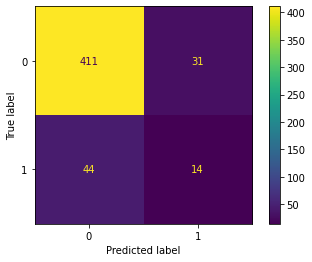

In [ ]:
cm_disp(conf_std).plot()
plt.show()

And this is why I do not use gridsearchCV, it simply does not find the best parameters. Running the model with best parameter set offered by it resulted in a 58% balanced accuracy.

If I run the model with a different set it is better.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"



 balanced accuracy: 0.6181151505695117


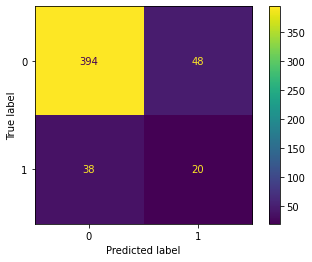

In [ ]:
iso_for = IsolationForest(n_estimators=100, contamination=0.135)
iso_for.fit(df_comb_std)
iso_for_pred = iso_for.predict(df_comb_std)

df_eval_std["iso_forest_pred"]=iso_for_pred
df_eval_std.loc[df_eval_std.iso_forest_pred==1, "iso_forest_pred"]="no"
df_eval_std.loc[df_eval_std.iso_forest_pred==-1, "iso_forest_pred"]="yes"
df_eval_sample_std=df_eval_std.drop(df_eval_std.loc[df_eval_std["labels"].isna()==True].index)
df_eval_sample_std.value_counts()

conf_std=confusion_matrix(df_eval_sample_std.labels, df_eval_sample_std.iso_forest_pred)
print("\n balanced accuracy:", bal_acc(conf_std))

cm_disp(conf_std).plot()
plt.show()

Still, this model does not beat the K-means model on the standardized input data.